# Prototype for music recommendation model

### based on music2vec: https://huggingface.co/m-a-p/music2vec-v1

In [1]:
!pip install tinytag

In [4]:
import torch
from torch import nn
import torchaudio.transforms as T

from transformers import Wav2Vec2FeatureExtractor
from torchaudio.transforms import Resample
from transformers import Wav2Vec2FeatureExtractor
from transformers import AutoModel

import librosa
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from tinytag import TinyTag

## Create track list

In [8]:
track_list = ['bellaire-brasil.mp3', 'daso-meine.mp3', 'sade-smoothoperator.mp3', 'adelphi-believe-in-you.mp3', 'adelphi-javelin.mp3', 'adelphi-people-everywhere.mp3', 'rolling-stones-honkytonk-woman.mp3', 'beatles-day-tripper.mp3']
# track_list = []

## Load model and process tracks

In [ ]:
import torchaudio.transforms as T

# model_name = "m-a-p/MERT-v1-95M"
model_name = "m-a-p/MERT-v1-330M"
resampling_rate = 24000

# load model and preprocessor
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

tokens = []
input_embeddings = []
output_embeddings = []

for id, track_path in enumerate(tqdm(track_list, desc="Processing Tracks")):
    # try read sampling rate from metdata, otherwise use 24 hz like music2vec
    try:
        mp3_metadata = TinyTag.get(track_path)
        sample_rate = mp3_metadata.samplerate
    except:
        sample_rate = 24000  # default

    print(f"Processing {track_path}. Identified sampling rate: {sample_rate}")

    # load audio file and preprocess
    audio_data, sr = librosa.load(track_path, sr=sample_rate)
    resampler = T.Resample(sample_rate, resampling_rate)
    input_audio = resampler(torch.from_numpy(audio_data))

    # create input embedding
    inputs = processor(input_audio, sampling_rate=resampling_rate, return_tensors="pt")
    input_embeddings.append(inputs)

    # forward pass prediction
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # print(outputs.hidden_states)
    output_embeddings.append((id, outputs))

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

configuration_MERT.py:   0%|          | 0.00/5.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/m-a-p/MERT-v1-330M:
- configuration_MERT.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_MERT.py:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/m-a-p/MERT-v1-330M:
- modeling_MERT.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Processing Tracks:   0%|          | 0/8 [00:00<?, ?it/s]

Processing bellaire-brasil.mp3. Identified sampling rate: 48000
Processing daso-meine.mp3. Identified sampling rate: 48000
Processing sade-smoothoperator.mp3. Identified sampling rate: 48000
Processing adelphi-believe-in-you.mp3. Identified sampling rate: 44100
Processing adelphi-javelin.mp3. Identified sampling rate: 44100
Processing adelphi-people-everywhere.mp3. Identified sampling rate: 44100
Processing rolling-stones-honkytonk-woman.mp3. Identified sampling rate: 44100
Processing beatles-day-tripper.mp3. Identified sampling rate: 44100


## Feature Extraction

In [ ]:
time_reduced_embeddings = []
last_state_embeddings = []

# fc-layer for feature aggregation
if model_name == "m-a-p/MERT-v1-95M":
    in_channels = 13
else:
    in_channels = 25
aggregator = nn.Conv1d(in_channels=in_channels, out_channels=1, kernel_size=1)

for label, token in tqdm(output_embeddings, desc="Extracting Features"):
    # version 1: time reduced and weighted
    all_layer_hidden_states = torch.stack(token.hidden_states).squeeze()
    time_reduced_hidden_states = all_layer_hidden_states.mean(-2)
    weighted_avg_hidden_states = aggregator(time_reduced_hidden_states.unsqueeze(0)).squeeze()
    time_reduced_embeddings.append(weighted_avg_hidden_states.detach().numpy())

    # version 2: average of last hidden state
    # last_hidden_state = token.last_hidden_state.squeeze()
    # averaged_last_hidden_state = last_hidden_state.mean(dim=0).squeeze()
    # last_state_embeddings.append(averaged_last_hidden_state)


time_reduced_embeddings = np.array(time_reduced_embeddings)
last_state_embeddings = np.array(last_state_embeddings)

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

### Save extracted features

In [ ]:
torch.save(time_reduced_embeddings, 'embeddings.pt')

### Load extracted features

In [3]:
time_reduced_embeddings = torch.load('embeddings.pt')

<ipython-input-3-4b60eada9fdc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  time_reduced_embeddings = torch.load('embeddings.pt')


## Pick embedding

In [6]:
extracted_embeddings = time_reduced_embeddings
# extracted_embeddings = last_state_embeddings

## Find next track using cosine similarity

In [9]:
# standardize embeddings
standardized_embeddings = StandardScaler().fit_transform(extracted_embeddings)

# calculate cosine similarities in regards to last track
cos_sim = cosine_similarity(standardized_embeddings[:-1, :], standardized_embeddings[-1, :].reshape(1, -1)).flatten()
most_similar_index = np.argmax(cos_sim)
most_similar_index

6

## t-SNE visualization

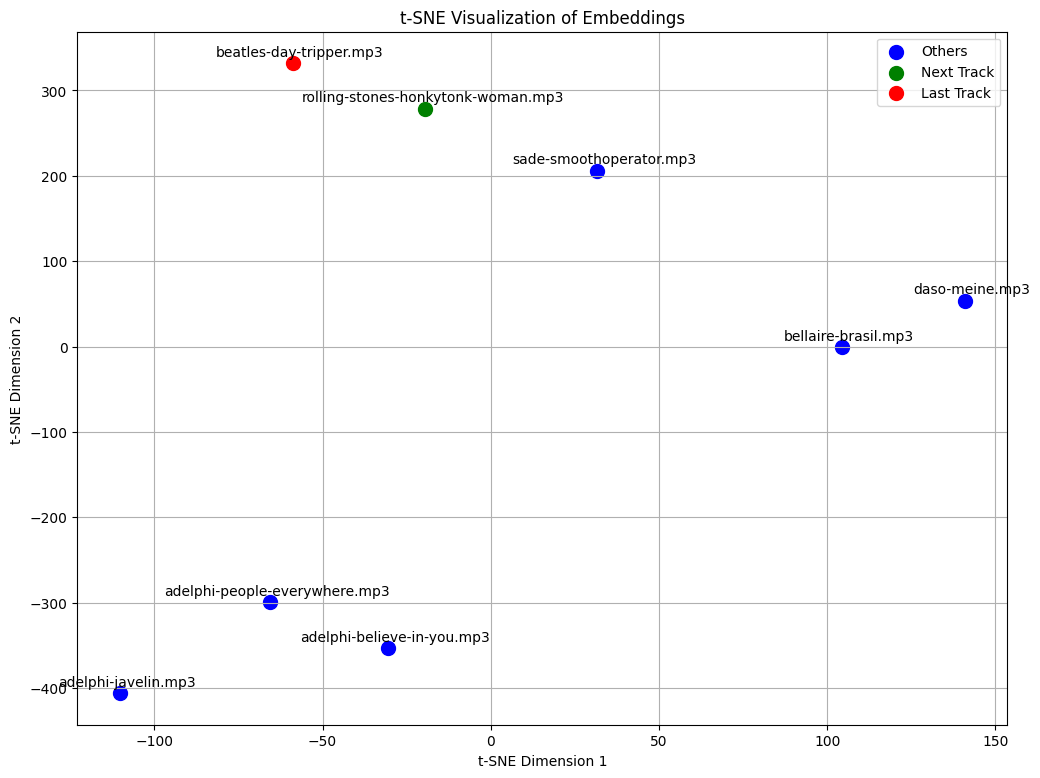

In [30]:
# perform t-SNE dimension reduction
tsne = TSNE(perplexity=2, metric ='cosine', random_state=42)
tsne_results = tsne.fit_transform(standardized_embeddings)

# plot t-SNE results
plt.figure(figsize=(12, 9))
plot_info = [('Last Track', 'red') if i==7 else ('Next Track', 'green') if i == most_similar_index else ('Others', 'blue') for i in range(len(track_list))]

for i, label in enumerate(track_list):
    track_legend, track_color = plot_info[i]
    plt.scatter(tsne_results[i, 0], tsne_results[i, 1], label=track_legend, color=track_color, s=100)
    plt.annotate(track_list[i], (tsne_results[i][0], tsne_results[i][1]), textcoords="offset points", xytext=(5, 5), ha='center')

plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)

# remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_legend = dict(zip(labels, handles))
plt.legend(unique_legend.values(), unique_legend.keys(), loc='best')

plt.show()

## Clustering and PCA

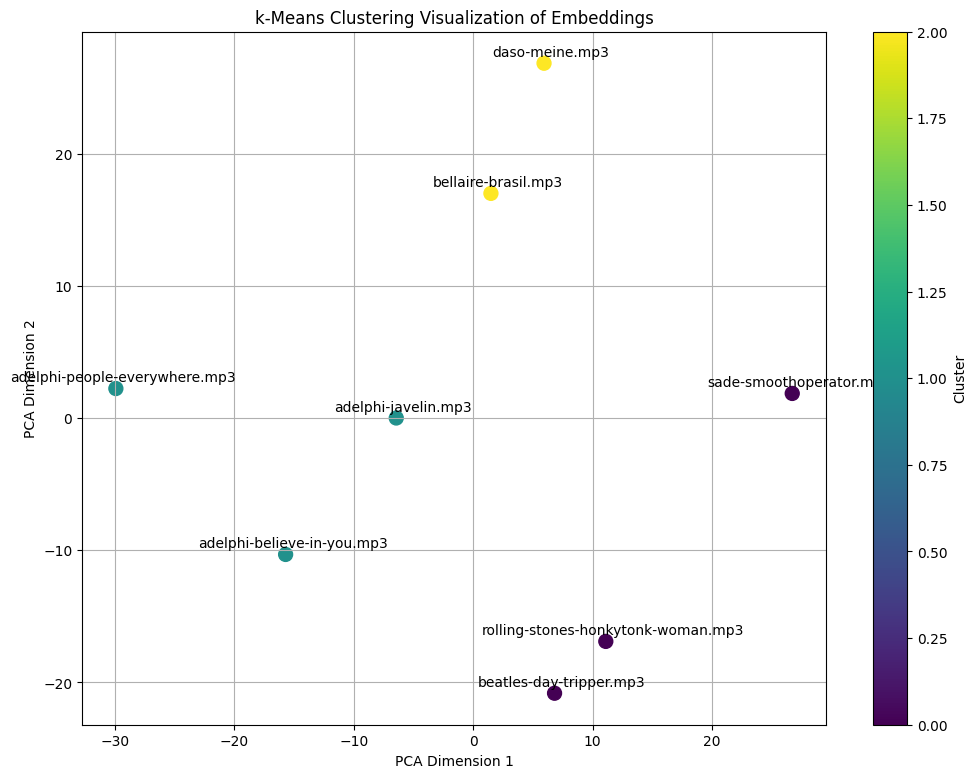

In [ ]:
# standardize embeddings
standardized_embeddings = StandardScaler().fit_transform(extracted_embeddings)

# apply k-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(standardized_embeddings)

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(standardized_embeddings)

# plot clustering results
plt.figure(figsize=(12, 9))
scatter = plt.scatter(pca_results[:, 0], pca_results[:, 1], c=cluster_labels, cmap='viridis', s=100)
plt.colorbar(scatter, label='Cluster')
for i, coord in enumerate(pca_results):
    plt.annotate(track_list[i], (coord[0], coord[1]), textcoords="offset points", xytext=(5, 5), ha='center')

plt.title("k-Means Clustering Visualization of Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)
plt.show()